In [1]:
import pandas as pd
import numpy as np
import matplotlib.finance as finplt
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import glob
import pickle
import datetime as dt
from MyModules.features import new_datetime
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
import warnings
from IPython.display import clear_output

/home/mt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/mt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/mt/anaconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [2]:
df = pd.read_csv(r'dukascopy - EURUSD_Candlestick_4_Hour_BID_31.12.2015-30.12.2016.csv',
                 parse_dates=[0], index_col=0, date_parser=lambda d: pd.datetime.strptime(d[:13], '%d.%m.%Y %H'))
df = df[(df.Open != df.High) & (df.Open != df.Low) & (df.Open != df.Close)]
cols = ['Candle Pattern', 'Same-sized Candle Trend Rejection', 'Engulfing Pattern', 'Immediate Trend Direction', 'Rejection',
        'Near Short-term Control', 'Near Long-term Control', 'In Excess Above Short-term Value', 'In Excess Below Short-term Value',
        'In Excess Above Long-term Value', 'In Excess Below Long-term Value', 'Rejected Short-term Control', 'Rejected Long-term Control',
        'Rejected Short-term Upper Limit', 'Rejected Short-term Lower Limit', 'Rejected Long-term Upper Limit', 'Rejected Long-term Lower Limit',
        'Near Short-term SR', 'Near Long-term SR', 'Near Sloped SR', 'Rejected Short-term SR line', 'Rejected Long-term SR line',
        'Rejected Sloped SR line', 'Long-term Trend Direction', 'In Excess of Long-term Value Area, Trend-following',
        'In Excess of Long-term Value Area, Counter-trend', 'Rejected Fibo level 236', 'Rejected Fibo level 382', 'Rejected Fibo level 618',
        'Closed above previous (green)', 'Close below previous (red)']

#toTrade = pd.read_csv(r'HTF trade labels.csv')                                      # If starting from last labeled datetime,
#min_w_lt, min_w, max_w = (100+len(toTrade), 550+len(toTrade), 650+len(toTrade))     # import with these lines
toTrade = pd.DataFrame(columns=['time', 'label'])                                    # Else use these lines to use
min_w_lt, min_w, max_w = (100, 550, 650)                                             # these starting points

df_longterm = df.iloc[min_w_lt:max_w, :].copy()                                      # long term context
df_window = pickle.load(open('df_window.p', 'rb'))                                   # short term window

In [3]:
def plot_ticks(df_window, longterm_SR, shortterm_SR, longterm_trend, lt_lower, lt_upper, shortterm_trend, st_lower, st_upper, sloped_sr_lines, sloped_sr_lines_starts):
    clear_output()
    plt.rcParams['figure.figsize'] = (24, 14)
    fig, ax = plt.subplots()
    plt.gca().get_xaxis().set_visible(False)
    fig.subplots_adjust(bottom=0.2)
    finplt.candlestick2_ohlc(ax, df_window.Open, df_window.High, df_window.Low, df_window.Close,
                             width=0.6, colorup='g', colordown='r', alpha=0.75)
    ax.autoscale_view()
    ax.add_patch(Rectangle((99-0.5, 0), 1.2, 10, facecolor='purple', alpha=0.3))
# Plot the SR lines
    for line in (lt for lt in longterm_SR if lt >= min(df_window.Low) and lt <= max(df_window.High)):
        plt.axhline(y=line, color='r', linewidth=2)
    for line in shortterm_SR:
        plt.axhline(y=line, color='b', linewidth=0.8)
# Plot the trend lines
    for i, trend in enumerate((shortterm_trend, st_lower, st_upper, longterm_trend, lt_lower, lt_upper)):
        lm = LinearRegression(n_jobs=-1)
        lm.fit(np.arange(5).reshape(-1, 1), trend[:5])
        y = lm.predict(np.arange(len(df_window)).reshape(-1, 1))
        plt.plot(y, '-.', color=params[i]['color'], linewidth=params[i]['linewidth'], alpha=params[i]['alpha'])
# Plot S+R lines with same slope as trend's control, determined by trend rejection candles
    for i in range(len(sloped_sr_lines)):
        if sloped_sr_lines[i] != []:
            lm = LinearRegression(n_jobs=-1)
            lm.fit(np.arange(len(sloped_sr_lines[i])).reshape(-1, 1), sloped_sr_lines[i])
            y = lm.predict(np.arange(len(df_window)-df_window.index.get_loc(sloped_sr_lines_starts[0])).reshape(-1, 1))
            plt.plot(np.add(df_window.index.get_loc(sloped_sr_lines_starts[0]), range(len(df_window)-df_window.index.get_loc(sloped_sr_lines_starts[0]))),
                     y, '--', color='purple', linewidth=3, alpha=0.7)
    plt.ylim(min(df_window.Low), max(df_window.High))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))
    [i.set_color("white") for i in plt.gca().get_yticklabels()]
    plt.show()

def trade_input(time, iteration, toTrade):
    print('   ' + str(df_window.index[99])[:13] + 'h')
    if df_window.iloc[99, 5] != 0:
        print(cat_map[df_window.iloc[99, 5]])
    for i in range(6, 34):
        if i not in (8, 9) and df_window.iloc[99, i] != 0:
            print(df_window.columns[i], end='')
            if i in [16, 17, 18, 19, 20, 21, 25, 26, 31, 32, 33]: print('  (from BELOW)' if df_window.iloc[99, i] == 1 else '  (from ABOVE)')
            else: print('')
    trade = input()
    toTrade = toTrade.append(pd.DataFrame([[time, trade]], columns=['time', 'label']), ignore_index=True)
    iteration += 1
    return toTrade, iteration

cat_map = {0: "No category", 1: "Hammer (body near high)", 2: "Inverted hammer (body near low)", 3: "Spinning top", 4: "Doji with close near high", 5: "Doji with close near low", 6: "Doji with close near middle", 7: "Marubozu", 8: "Hanging man", 9: "Shooting star"}
params = {0: {'color': 'teal', 'linewidth': 3, 'alpha': 1}, 1: {'color': 'teal', 'linewidth': 2, 'alpha': 0.6}, 2: {'color': 'teal', 'linewidth': 2, 'alpha': 0.6}, 3: {'color': 'green', 'linewidth': 3, 'alpha': 1}, 4: {'color': 'green', 'linewidth': 2, 'alpha': 0.6}, 5: {'color': 'green', 'linewidth': 2, 'alpha': 0.6}}
iteration = 0

### Label the points where it's perfect to buy low/ sell high
Will have a new df_window in lower timeframe to find the exact time to execute an actual trade, when a label at this higher timeframe indiciates such a perfect time

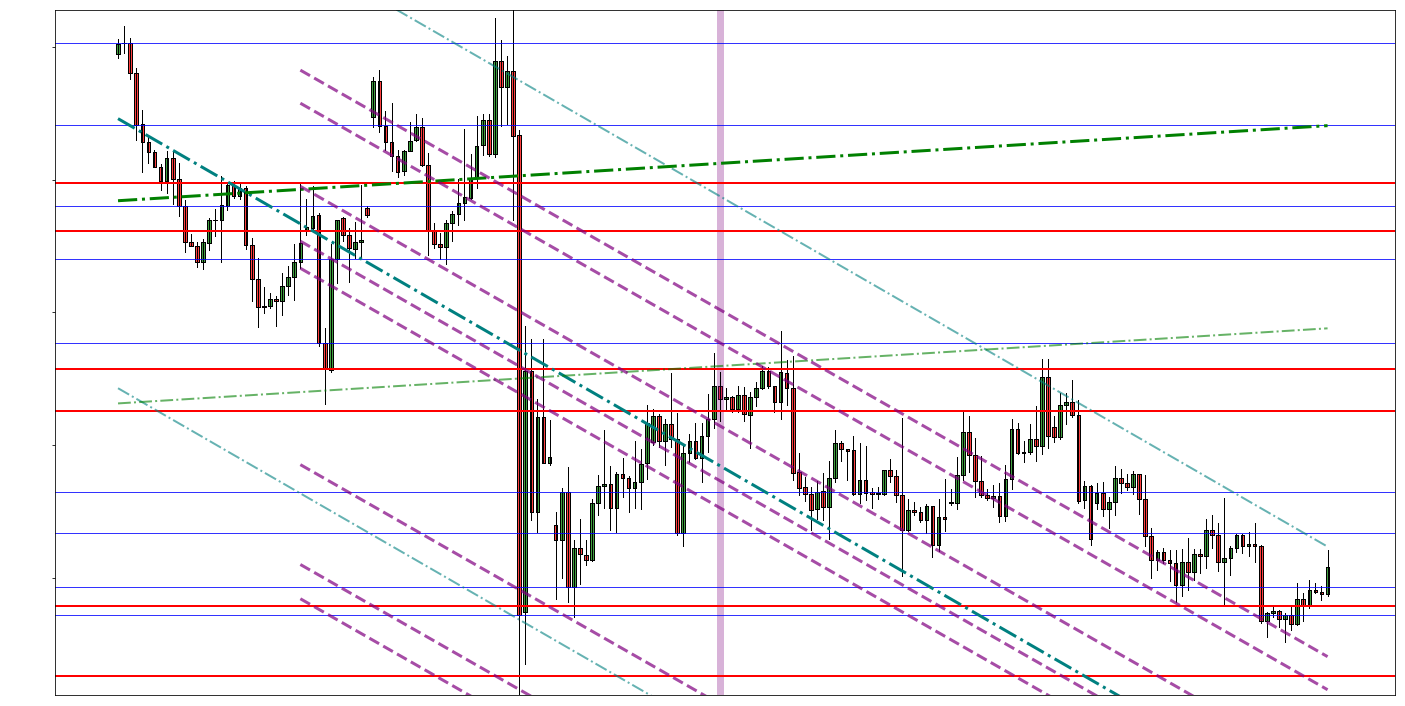

   2016-07-01 16h
Spinning top
In Excess Below Long-term Value
Near Sloped SR
Rejected Long-term SR line  (from BELOW)
In Excess of Long-term Value Area, Counter-trend
done


In [4]:
warnings.simplefilter(action='ignore', category=DeprecationWarning)
while True:
    df_longterm, df_window, shortterm_SR, longterm_SR, shortterm_trend, st_lower, st_upper, longterm_trend, lt_lower, lt_upper, sloped_sr_lines, sloped_sr_lines_starts \
        = new_datetime(df_longterm, df_window, df.iloc[max_w+iteration, :], pip_closeness_tol=0.0008)
    plot_ticks(df_window.append(df.iloc[max_w+iteration+1 : max_w+iteration+101, :4])[df_window.columns.tolist()], longterm_SR, shortterm_SR, longterm_trend.reindex(df_window.index, axis=0), lt_lower.reindex(df_window.index, axis=0), lt_upper.reindex(df_window.index, axis=0), shortterm_trend, st_lower, st_upper, sloped_sr_lines, sloped_sr_lines_starts)
    toTrade, iteration = trade_input(df_window.index[-1], iteration, toTrade)
    if toTrade.iloc[-1, 1] == 'done':
        toTrade = toTrade.drop(toTrade.index[-1])
        break

In [5]:
# Export csv labels
filename = 'HTF trade labels.csv' if not glob.glob('HTF trade labels.csv') else 'HTF trade labels (1).csv'
toTrade.to_csv(filename, index=False)
# Dump df_window
filename = 'df_window.p' if not glob.glob('df_window.p') else 'df_window (1).p'
pickle.dump(df_window, open(filename, 'wb'))